# Проект А/B тестирование

## Цель:
проанализировать влияние изменения рекомендательной системы на конверсию в целевое действие для пользователей Европейского союза

## Задачи:


*   оценить корректность проведения теста


*   проанализировать результаты теста





## Техническое задание:
* Название теста: recommender_system_test;
* Группы: А (контрольная), B (новая платёжная воронка);
* Дата запуска: 2020-12-07;
* Дата остановки набора новых пользователей: 2020-12-21;
* Дата остановки: 2021-01-04;
* Аудитория: 15% новых пользователей из региона EU;
* Назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
* Ожидаемое количество участников теста: 6000.
* Ожидаемый эффект: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10%:
конверсии в просмотр карточек товаров — событие product_page
просмотры корзины — product_cart
покупки — purchase.

## 1. Предобработка данных

In [1]:
#обновляем библиотеку
! pip install plotly==5.7.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.8/28.8 MB 37.9 MB/s eta 0:00:00
  Attempting uninstall: plotly
    Found existing installation: plotly 5.15.0
    Uninstalling plotly-5.15.0:
      Successfully uninstalled plotly-5.15.0


In [2]:
# импортируем библиотеки
import pandas as pd
import scipy.stats as st
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from plotly import graph_objects as go
import plotly.express as px
import math as mth
from statsmodels.stats.multitest import multipletests
from numpy import median
import requests
from tqdm import tqdm
from tqdm.notebook import tqdm as tqdm_notebook
# конвертеры, которые позволяют использовать типы pandas в matplotlib
register_matplotlib_converters()

In [3]:
import plotly
plotly.__version__

'5.7.0'

In [4]:
#задаем размеры графиков
sns.set(rc={'figure.figsize':(12,6)})
# определяем палитру
sns.set_palette('pastel')
# задаем стиль графиков
sns.set_style('whitegrid')

In [5]:
# загружаем данные
events, participants, new_users, marketing = (
    pd.read_csv('/content/final_ab_events.csv'),
    pd.read_csv('/content/final_ab_participants.csv'),
    pd.read_csv('/content/final_ab_new_users.csv'),
    pd.read_csv('/content/ab_project_marketing_events.csv')
    )

In [6]:
# функция для изучения основной информации о данных, проверки на пропуски и дубликаты
def data_info(data):
    return (display(data.head()),
           data.info(),
           print('Количество пропусков:', data.isna().sum()),
           print('Количество явных дубликатов:', data.duplicated().sum()),
           print('Доля явных дубликатов', round((data.duplicated().sum()) / len(data) * 100, 2)))

In [7]:
data_info(events)

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB
Количество пропусков: user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64
Количество явных дубликатов: 0
Доля явных дубликатов 0.0


(None, None, None, None, None)

In [8]:
# уникальные события в данных
events['event_name'].value_counts()

login           189552
product_page    125563
purchase         62740
product_cart     62462
Name: event_name, dtype: int64

In [9]:
# значения в столюце details
events['details'].value_counts()

4.99      46362
9.99       9530
99.99      5631
499.99     1217
Name: details, dtype: int64

In [10]:
# преобразование данных о времени и дате
events['event_dt'] = pd.to_datetime(events['event_dt'])

В данных по событиям явных дубликатов нет. Пропуски только в столбце c доп. данными о событиях, так как в нем, как видим, только информация о стоимости покупки для события purchase, которой нет у других категорий событий. Столбец с датой и временем приведен к соответствующему формату

In [11]:
data_info(participants)

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB
Количество пропусков: user_id    0
group      0
ab_test    0
dtype: int64
Количество явных дубликатов: 0
Доля явных дубликатов 0.0


(None, None, None, None, None)

В таблице участников теста явных дубликатов и пропусков нет. Здесь в данных 2 группы участников теста и 2 вида теста

In [12]:
data_info(new_users)

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB
Количество пропусков: user_id       0
first_date    0
region        0
device        0
dtype: int64
Количество явных дубликатов: 0
Доля явных дубликатов 0.0


(None, None, None, None, None)

In [13]:
# преобразование даты в нужный формат
new_users['first_date'] = pd.to_datetime(new_users['first_date'])

В данном датафрейме пропусков и явных дубликатов нет. Столбец с датой преобразован в соответствующий формат

In [14]:
data_info(marketing)

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes
Количество пропусков: name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64
Количество явных дубликатов: 0
Доля явных дубликатов 0.0


(None, None, None, None, None)

In [15]:
# преобразование даты в нужный формат
marketing['start_dt'] = pd.to_datetime(marketing['start_dt'])
marketing['finish_dt'] = pd.to_datetime(marketing['finish_dt'])

 В данных о маркетинговых мероприятих пропусков и явных дубликатов также нет. Столбцы с датами преобразованы в соответствующий формат

Данные подготовлены к анализу

## 2. Оценка корректности проведения теста

In [16]:
# объединяем таблицы
df = new_users.merge(events, on='user_id', how='outer')

In [17]:
df

,user_id,first_date,region,device,event_dt,event_name,details
0,D72A72121175D8BE,2020-12-07,EU,PC,2020-12-07 21:52:10,product_page,NaN
1,D72A72121175D8BE,2020-12-07,EU,PC,2020-12-07 21:52:07,login,NaN
2,F1C668619DFE6E65,2020-12-07,N.America,Android,2020-12-07 16:38:09,product_page,NaN
3,F1C668619DFE6E65,2020-12-07,N.America,Android,2020-12-08 02:02:34,product_page,NaN
4,F1C668619DFE6E65,2020-12-07,N.America,Android,2020-12-23 14:35:41,product_page,NaN
...,...,...,...,...,...,...,...
443342,1C7D23927835213F,2020-12-20,EU,iPhone,2020-12-23 15:47:23,login,NaN
443343,1C7D23927835213F,2020-12-20,EU,iPhone,2020-12-25 12:31:04,login,NaN
443344,1C7D23927835213F,2020-12-20,EU,iPhone,2020-12-27 03:51:35,login,NaN
443345,8F04273BB2860229,2020-12-20,EU,Android,2020-12-20 03:17:17,product_cart,NaN


In [18]:
df = df.merge(participants, on='user_id', how='outer')

In [19]:
df

,user_id,first_date,region,device,event_dt,event_name,details,group,ab_test
0,D72A72121175D8BE,2020-12-07,EU,PC,2020-12-07 21:52:10,product_page,NaN,A,recommender_system_test
1,D72A72121175D8BE,2020-12-07,EU,PC,2020-12-07 21:52:07,login,NaN,A,recommender_system_test
2,F1C668619DFE6E65,2020-12-07,N.America,Android,2020-12-07 16:38:09,product_page,NaN,NaN,NaN
3,F1C668619DFE6E65,2020-12-07,N.America,Android,2020-12-08 02:02:34,product_page,NaN,NaN,NaN
4,F1C668619DFE6E65,2020-12-07,N.America,Android,2020-12-23 14:35:41,product_page,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
449951,1C7D23927835213F,2020-12-20,EU,iPhone,2020-12-23 15:47:23,login,NaN,B,interface_eu_test
449952,1C7D23927835213F,2020-12-20,EU,iPhone,2020-12-25 12:31:04,login,NaN,B,interface_eu_test
449953,1C7D23927835213F,2020-12-20,EU,iPhone,2020-12-27 03:51:35,login,NaN,B,interface_eu_test
449954,8F04273BB2860229,2020-12-20,EU,Android,2020-12-20 03:17:17,product_cart,NaN,NaN,NaN


In [20]:
# определяем максимальную и минимальную дату регистрации
df.agg({'first_date':[min, max]})

,first_date
min,2020-12-07
max,2020-12-23


Согласно ТЗ, период регистрации должен быть с 7 по 21 декабря 2020. У нас данные с регистрацией до 23 декабря 2020. В таблице выше видно, что у нас несколько тестов, проверим даты регистрации именно в наш тест

In [21]:
# даты регистрации в наш тест
df.query('ab_test == "recommender_system_test"').agg({'first_date':[min, max]})

,first_date
min,2020-12-07
max,2020-12-21


Здесь даты регистрации совпадают с ТЗ

In [22]:
# доля европейцев, попавших в наш тест
((df.query('region == "EU" and ab_test == "recommender_system_test"')['user_id'].nunique()) /
 (df.query('region == "EU" and first_date <= "2020-12-21"')['user_id'].nunique()))

0.15

Аудитория теста: 15% новых пользователей из региона EU, что соответствует ТЗ

In [23]:
# количество участников теста
(df.query('region == "EU" and ab_test == "recommender_system_test"')['user_id'].nunique())

6351

На данном этапе количество пользователей в нашем тесте немного больше, чем ТЗ, но нам еще нужно проверить другие критерии

In [24]:
# посмотрим, сколько у нас тестов
df['ab_test'].unique()

array(['recommender_system_test', nan, 'interface_eu_test'], dtype=object)

В данных 2 вида тестов и есть пользователи, которые не попали ни в один тест

In [25]:
# уберем пользователей которые не попали ни в один тест
df = df.query('ab_test == "recommender_system_test" or ab_test == "interface_eu_test"')

In [26]:
# проверим, сколько у нас групп
df['group'].unique()

array(['A', 'B'], dtype=object)

У нас в данных 2 группы:А (контрольная), B (новая платёжная воронка), что соответствует ТЗ

Проверим, нет ли пересечения пользователей между экспериментальными группами 2х тестов. Также проверим, не попали ли пользователи из группы В второго теста в нашу группу А. Так как обе группы А видят неизмененную версию сайта, то пересечение А-А не страшно

In [27]:
# отбираем пользователей группы В из теста interface_eu_test
interface_b = df.query('group == "B" and ab_test == "interface_eu_test"')['user_id'].unique()

In [28]:
# проверим, есть ли песечения в группах В 2х тестов
df.query('group == "B" and ab_test == "recommender_system_test" and user_id in @interface_b')['user_id'].nunique()

344

344 пользователя попали в экспериментальные группы обоих тестов. Проверим, не попали ли пользователи из группы В второго теста в нашу группу А

In [29]:
# проверим, есть ли пересечения между группой А нашего теста и группой В второго теста
df.query('group == "A" and ab_test == "recommender_system_test" and user_id in @interface_b')['user_id'].nunique()

439

439 пользователей из группы В второго теста попали в группу А нашего теста

Чтобы избежать влияния на наши результаты второго теста, удалим пересекащихся пользователей.

In [30]:
# отберем пользователей, попавших в наш тест и не попавших в группу В второго теста
df = df.query('ab_test == "recommender_system_test" and user_id not in @interface_b')

In [31]:
# проверяем нет ли пересечения между группами нашего теста
df.groupby('user_id').agg({'group':'nunique'}).query('group > 1').count()

group    0
dtype: int64

Пользователи между группами не пересекаются

In [32]:
# определяем максимальную и минимальную дату событий
df.agg({'event_dt':[min, max]})

,event_dt
min,2020-12-07 00:05:57
max,2020-12-30 12:42:57


Очевидно, тест был остановлен на 5 дней раньше, чем указано в ТЗ, значит, не все пользователи успеют прожить заданный в ТЗ период 14 дней

In [33]:
# проверим, есть ли пользователи не совершившие ни одного события
df['event_dt'].isna().sum()

2674

2674 пользователя не совершали событий, а только зарегистрировались. Влияние изменения рекомендательной системы на их поведение мы не можем оценить, поэтому их нужно исключить их исследования



In [34]:
# считаем лайфтайм
df['lifetime'] = (df['event_dt'] - df['first_date']).dt.days

In [35]:
df['lifetime'].unique()

array([ 0.,  1.,  3.,  9., 11., 23.,  2.,  5., 21., 10., 13., 19., nan,
        4.,  7.,  6., 22., 15.,  8., 20., 18., 12., 17., 16., 14.])

In [36]:
# отбираем события, у которых лайфтайм не больше 14 дней и избавляемся от неактивных пользователей
df = df.query('lifetime <= 14')

In [37]:
# посмотрим, какие у нас есть регионы
df['region'].unique()

array(['EU', 'APAC', 'CIS', 'N.America'], dtype=object)

Так как по ТЗ у нас должны быть пользователи только из Европейского союза, уберем пользователей из других регионов

In [38]:
# отбираем пользователей только из EU
df = df.query('region == "EU"')

In [39]:
# уникальные пользователи
(print('Количество уникальных пользователей:', df['user_id'].nunique()))

Количество уникальных пользователей: 3050


In [40]:
# уникальные пользователи по группам
df.groupby('group')['user_id'].nunique()

group
A    2279
B     771
Name: user_id, dtype: int64

Распределение по группам неравномерное. В группе А почти в 3 раза больше пользователей, чем в группе В

Проверим, были ли маркетинговые события в период проведения теста


In [41]:
# создадим переменные с временным периодом теста
start = df['event_dt'].min()
finish = df['event_dt'].max()

In [42]:
# совпадающие маркетинговые мероприятия
marketing.query('start_dt > @start or finish_dt > @start')

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


С периодом проведения теста совпали 2 маркетинговые мероприятия, но одно из них проводилось для региона СНГ. Для Евросоюза проводилось в этот период только Рождественская акция, что могло повлиять на поведение пользователей в последние 6 дней. Однако, она влияла как на поведение пользователей группы А, так и на поведение пользователей группы В, поэтому на конверсию не повлияет. Однако, об этой акции стоит помнить при расчете абсолютных показателей


Данные были собраны с нарушением ТЗ, с пересечением с конкурирующим тестом и праздниками. После очистки данных количество пользователей сократилось до 3050

## 3. Исследовательский анализ данных


### Количество событий на пользователя в выборках

In [43]:
# собираем данные по группам для графиков
group_a = df.query('group == "A"').groupby('user_id').agg({'event_name':'count'}).reset_index()
group_b = df.query('group == "B"').groupby('user_id').agg({'event_name':'count'}).reset_index()

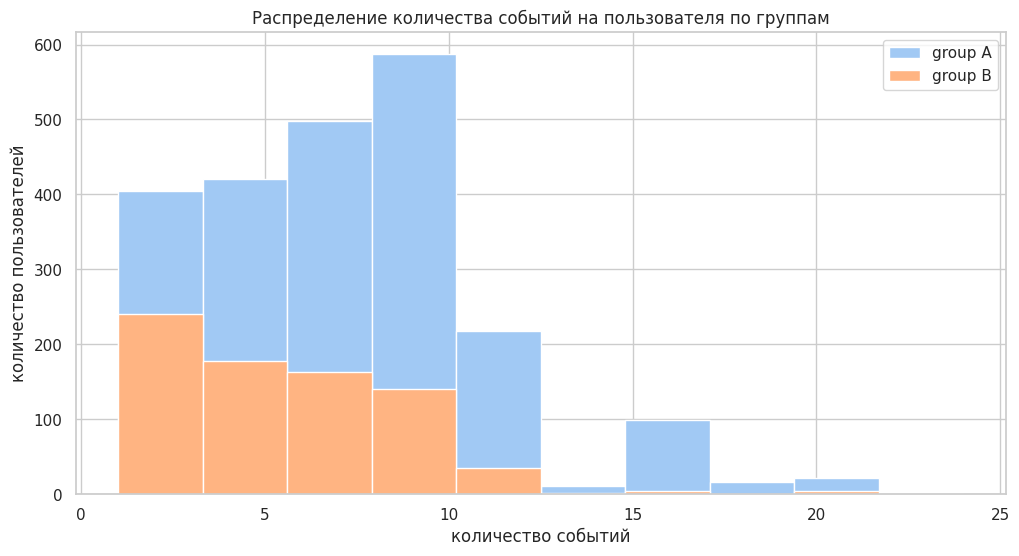

In [44]:
# строим график
group_a['event_name'].hist(label='group A')
group_b['event_name'].hist(label='group B')
plt.title('Распределение количества событий на пользователя по группам')
plt.xlabel('количество событий')
plt.ylabel('количество пользователей')
plt.legend()
plt.show();

In [45]:
# кол-во событий на пользователя по группам
print(group_a['event_name'].describe())
print(group_b['event_name'].describe())

count    2279.000000
mean        6.955244
std         3.852837
min         1.000000
25%         4.000000
50%         6.000000
75%         9.000000
max        24.000000
Name: event_name, dtype: float64
count    771.000000
mean       5.425422
std        3.249068
min        1.000000
25%        3.000000
50%        4.000000
75%        7.000000
max       24.000000
Name: event_name, dtype: float64


Как видим, события на пользователя по группам распределены неравномерно. В группе А их больше и количество растет. В группе В событий на пользователя в целом меньше и количество падает. Совпадает только минимальное (1) и максимальное (24) количество событий. Среднее количество в группе А выше, медианное тоже.

Посмотрим на распределение событий по этапам

In [46]:
# строим график
fig = px.histogram(df, x="event_name", color="group", text_auto=True).update_xaxes(categoryorder='total descending')
fig.update_layout(title="Количество событий по этапам и по группам",
                  xaxis_title="Событие",
                  yaxis_title="Количество")

fig.show()

На всех этапах лидирует группа А. В обеих группах: лидирует событие login. Далее, с резким падением в количестве пользователей, следует событие product page -просмотр карточек товаров. Покупок в группе А больше, чем добалений в корзину, а в группе B немного меньше. Корзина может быть уже, чем покупки, так как есть функция покупки в один клик, без перехода в корзину.

### Число событий в выборках по дням

In [47]:
# добавим отдельный столбец с датой
df['date'] = pd.to_datetime(df['event_dt'].dt.date)

In [48]:
# группируем данные по группам и датам
dist = df.groupby([ 'group', 'date'])['event_name'].count().reset_index()

In [49]:
# строим график
fig = px.histogram(dist, x="date", y="event_name",
             color='group', barmode='group',text_auto=True, nbins=24)
fig.update_layout(title="Распределение событий в выборках по дням",
                  xaxis_title="Дата",
                  yaxis_title="Количество событий")
fig.show()

До 14 декабря события распределялись между группами довольно равномерно. Однако, 14 декабря в группе А произошел резкий скачок.
Далее в группе А количество событий стремительно растет. Пик 21 декабря может быть обусловлен тем, что это последня дата набора в тест, то есть на эту дату приходится ниабольшее количество пользователей. Далее набор пользователей был остановлен (причем раньше времени), и количество событий стало снижаться. Между группами А и В прослеживается существенная разница, что, скорее всего, обусловлено тем, что распределение пользователей по группам неравномерно. Возможно также, что произошла какая-то техническая ошибка

In [50]:
# кол-во пользователей по группам и событиям
fnl_group = (df
             .pivot_table(index='event_name', columns='group', values='user_id', aggfunc='nunique')
             .reset_index()
             .reindex([0, 2, 1, 3])
)

In [51]:
fnl_group

group,event_name,A,B
0,login,2279,770
2,product_page,1476,429
1,product_cart,686,214
3,purchase,734,219


In [52]:
# строим воронку событий по группам
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'Group A',
    y = fnl_group['event_name'],
    x = fnl_group['A'],
    textinfo = "value + percent previous"))

fig.add_trace(go.Funnel(
    name = 'Group B',
    orientation = "h",
    y = fnl_group['event_name'],
    x = fnl_group['B'],
    textposition = "inside",
    textinfo = "value+percent previous"))



fig.update_layout(title_text='Воронка событий по тестовым группам')
fig.show()

По воронке можно отметить нюанс: "покупок" больше, чем "корзин". Это может говорить о том, что на платформе нестрогая воронка продаж, и можно приобрести продукт, минуя некоторые этапы

Как видим, улучшения конверсии в группе В по сравнению с группой А нет. Планируемый результат не достигнут



Распределение пользователей по группам изначально неравномерно. Динамика событий в группе А сильно отличается от группы В. Ожидаемое увеличение конверсии на 10% после изменения рекомендательной системы не наблюдается.

In [53]:
# распределение пользователей по утройствам
device = df.pivot_table(index='device', columns='group', values='user_id', aggfunc='nunique').reset_index()
device['share_a'] = round(device['A'] / device['A'].sum(), 2)
device['share_b'] = round(device['B'] / device['B'].sum(), 2)
device

group,device,A,B,share_a,share_b
0,Android,1003,360,0.44,0.47
1,Mac,211,67,0.09,0.09
2,PC,593,185,0.26,0.24
3,iPhone,472,159,0.21,0.21


Стоит отметить, что по устройствам (то есть доля, использующих определенное устройство в группе А и в группе В) пользователи распределены довольно равномерно по группам,

## Особенности данных для А/В тестирования



*   выборка должна быть достаточно большой для достижения желаемых результатов. У нас после очистки данных размер выборки сократился почти в 2 раза

*  следует избегать несоответствия соотношения выборок, у нас выборка А почти в 3 раза больше
*   необходимо выдерживать запланированную продолжительность теста, у нас тест был остановлен на 5 дней раньше


*  при делении трафика необходимо учитывать устройства, с которых пользователи используют продукт. В данном случае у нас распределение корректно


*   при проведении теста стоит избегать влияния сезонности, акций и праздников. У нас период проведения теста совпадает с Рождеством и акцией
*   стоит избегать влияния других тестов, аудитория не должна пересекаться. У нас были пересечения с другим тестом, таких пользователей пришлось удалить


*   следует избегать аномалий и выбросов, у нас есть резкие скачки в данных и, в целом, поведение группы А не стабильно
*   при множественном тестировании увеличивается риск ложноположительного результата, необходимо применять корректировку стат. значимости







Таким образом, на имеющихся данных нельзя рассчитывать на высокую точность и качество результатов проведенного теста

## Оценка результатов А/Б тестирования

In [54]:
# список для P-value
p_list = []

In [55]:
# создаем функцию для теста
def z_test(gr1, gr2, event_name, alpha):
    tr1 = fnl_group.loc[event_name, gr1]
    tr2 = fnl_group.loc[event_name, gr2]
    su1 = group_users.loc[gr1, 'user_id']
    su2 = group_users.loc[gr2, 'user_id']
    # пропорция успехов в первой группе:
    p1 = tr1 / su1
    # пропорция успехов во второй группе:
    p2 = tr2 / su2
    # пропорция успехов в комбинированном датасете:
    p_combined = (tr1 + tr2) / (su1 + su2)
    # разница пропорций в датасетах
    difference = p1 - p2
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1 / su1 + 1 / su2))
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    p_list.append(p_value)
    print('Сравниваемые группы: {} и {}, событие: {}, P-value: {p_value:.6f}'
          .format(gr1, gr2, event_name, p_value=p_value))
    if (p_value < alpha):
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

In [56]:
# сколько пользователей в каждой группе
group_users = df.groupby('group').agg({'user_id':'nunique'})
group_users

,user_id
group,
A,2279
B,771


In [57]:
# вернем названия событий в индексы
fnl_group = fnl_group.set_index(fnl_group.columns[0])

In [58]:
fnl_group

group,A,B
event_name,,
login,2279,770
product_page,1476,429
product_cart,686,214
purchase,734,219


Проверим, находят ли статистические критерии разницу между группами А и В.
> Сформулируем гипотезы:

> Нулевая: доли пользователей, совершивших события по группам, равны.

> Альтернативная: доли пользователей, совершивших события по группам, неравны.

> Установим уровень статистической значимости 0.05.
> Применим z-test для проверки гипотезы о равенстве долей.

In [59]:
for event_name in fnl_group.index:
    z_test('A', 'B', event_name, 0.05)
    print()

Сравниваемые группы: A и B, событие: login, P-value: 0.085513
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Сравниваемые группы: A и B, событие: product_page, P-value: 0.000006
Отвергаем нулевую гипотезу: между долями есть значимая разница

Сравниваемые группы: A и B, событие: product_cart, P-value: 0.217211
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Сравниваемые группы: A и B, событие: purchase, P-value: 0.048943
Отвергаем нулевую гипотезу: между долями есть значимая разница



При множественной проверке гипотез увеличивается риск ложноположительного результата, найти различия там, где их на самом деле нет. Применим корректировку по методу Шидака (чтобы не снижать значительно мощность тестов), для корректировки уровня значимости.

In [60]:
# применим корректировку по методу Шидака
corr_sidak = multipletests(p_list, alpha=0.05, method='sidak')
corr_sidak

(array([False,  True, False, False]),
 array([3.00625800e-01, 2.44826977e-05, 6.24527310e-01, 1.81861325e-01]),
 0.012741455098566168,
 0.0125)

На имеющихся данных, на уровне значимости 5% и при применении корректировки Шидака для множественного теста нет оснований отвергнуть нулевую гипотезу о равенстве между группами в трех случаях:

>сравниваемые группы А и В, событие login

>сравниваемые группы А и В, событие product cart

>сравниваемые группы А и В, событие purchase

>Вывод: в этих трех случаях различий между группами нет.

>В случае с событием product page есть основания отвергнуть нулевую гипотезу, следовательно различия между группами есть

## Выводы



*   данные для теста были собраны с нарушением ТЗ


*   на результаты теста могли повлиять маркетинговые мероприятия и праздники


*   во время набора пользователей в группы, очевидно, были какие-то технические ошибки
*   ожидаемый результат увеличения конверсии не достигнут


*  при проверке гипотезы о равенстве долей различия между группами обнаружены только на этапе product page. На этапах login, product cart и, главное, purchase различий между группами нет

---
Таким образом, на имеющихся данных нет оснований сделать вывод о том, что изменение рекомендательной системы улучшило целевые показатели




## Рекомендации



*   необходимо провести тест заново с соблюдением ТЗ
*   учитывать при проведении теста сезонные события и маркетинговые мероприятия

